### Todos
- look at torch lighting
- look at small ResNet (e.g. ResNet12)
- clean up code
- integrate weights and biases

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import numpy as np
import random
from os import PathLike
import copy
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from typing import List, Tuple
from tqdm.notebook import tqdm

### Dataloader

In [2]:
# Create dataloader
class DroneImagesDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = np.genfromtxt(csv_file, delimiter=',', dtype=None, encoding=None, skip_header=True)
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.annotations[index][0]
        image = cv2.imread(img_path)
        left, forward, center = float(self.annotations[index][1]), float(self.annotations[index][2]), float(self.annotations[index][3])
        y_label = torch.tensor([left, forward, center])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    
    def __len__(self):
        return len(self.annotations)

#### Transformer

In [3]:
# transform that makes it a tensor and crops the bottom third of the image
IMAGE_TRANSFORM = transforms.Compose([
    transforms.Lambda(lambda x: x[:,80:,:]),
    transforms.ToPILImage(),
    transforms.Resize((240, 80)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

#### Examples

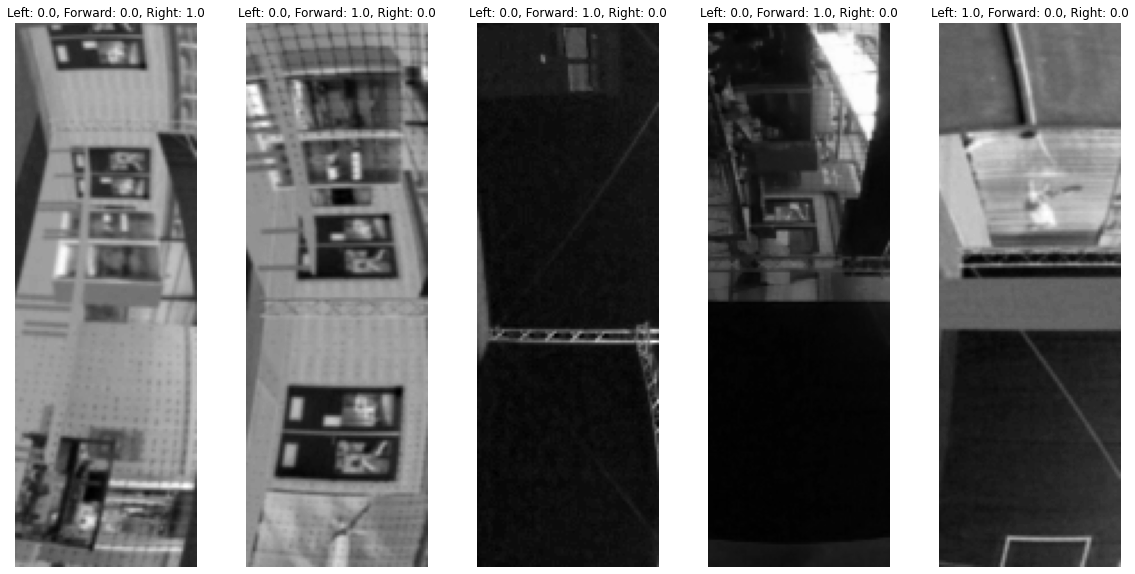

In [5]:
dataset = DroneImagesDataset('images_with_label.csv', transform=IMAGE_TRANSFORM)

# show 5 random grayscale images
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    image, label = dataset[random.randint(0, len(dataset))]
    ax[i].imshow(image.squeeze(0), cmap='gray')
    ax[i].set_title(f'Left: {label[0]}, Forward: {label[1]}, Right: {label[2]}')
    ax[i].axis('off')

# # show 5 random RGB images
# fig, ax = plt.subplots(1, 5, figsize=(20, 10))
# for i in range(5):
#     image, label = dataset[random.randint(0, len(dataset))]
#     ax[i].imshow(image.permute(1, 2, 0))
#     ax[i].set_title(f'Left: {label[0]}, Forward: {label[1]}, Center: {label[2]}')
#     ax[i].axis('off')
    
# # Show how many samples we have for each label
# left = 0
# forward = 0
# right = 0
# for i in range(len(dataset)):
#     _, label = dataset[i]
#     if label[0] == 1:
#         left += 1
#     elif label[1] == 1:
#         forward += 1
#     elif label[2] == 1:
#         right += 1

# print(f'Left: {left}, Forward: {forward}, Right: {right}')

#### Train, Val, Test dataloaders

In [6]:
def dataloaders(
        dataset_path: PathLike = 'images_with_label.csv',
        val_ratio: float = 0.2,
        test_ratio: float = 0.1,
        batch_size: int = 32,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create dataloaders for the training, validation, and test sets.

    Args:
        val_ratio: The ratio of the dataset to use for validation.
        test_ratio: The ratio of the dataset to use for testing.
        batch_size: The number of samples in each batch.

    Returns:
        A tuple of DataLoaders for the training, validation, and test sets.
    """

    dataset = DroneImagesDataset(csv_file=dataset_path, transform=IMAGE_TRANSFORM)

    # Split the dataset into training, validation, and test sets
    num_samples = len(dataset)
    num_val_samples = int(val_ratio * num_samples)
    num_test_samples = int(test_ratio * num_samples)
    num_train_samples = num_samples - num_val_samples - num_test_samples
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [num_train_samples, num_val_samples, num_test_samples]
    )

    # Create DataLoaders for the training, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2, persistent_workers=True)

    return train_loader, val_loader, test_loader

# Create dataloaders
train_loader, val_loader, test_loader = dataloaders()

### Model

In [16]:
# Create a CNN
class CNN(nn.Sequential):
    def __init__(self):
        conv1 = nn.Conv2d(1, 32, kernel_size=(5,5), stride=1, padding=1) # use 64 / 128 channels?
        act1 = nn.ReLU()
        pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout1 = nn.Dropout(0.2)

        conv2 = nn.Conv2d(32, 32, kernel_size=(5,5), stride=1, padding=1)
        act2 = nn.ReLU()
        pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout2 = nn.Dropout(0.1)

        conv3 = nn.Conv2d(32, 32, kernel_size=(5,5), stride=1, padding=1)
        act3 = nn.ReLU()
        pool3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout3 = nn.Dropout(0.1)

        conv4 = nn.Conv2d(32, 32, kernel_size=(5,5), stride=1, padding=1)
        act4 = nn.ReLU()
        pool4 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout4 = nn.Dropout(0.1)

        flatten = nn.Flatten()

        fc1 = nn.Linear(1248, 3)

        super(CNN, self).__init__(
            conv1, act1, pool1, dropout1,
            conv2, act2, pool2, dropout2,
            conv3, act3, pool3, dropout3,
            conv4, act4, pool4, dropout4,
            flatten,
            fc1
        )

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def evaluate_model(model, loader):
    """
    Evaluate the model on the given dataset.

    Args:
        model: The model to evaluate.
        loader: The DataLoader for the dataset.

    Returns:
        The average loss and accuracy.
    """
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, actual = torch.max(labels, 1)
            correct += (predicted == actual).sum().item()
            total += labels.size(0)
            
    return total_loss / len(loader), correct / total

In [19]:
num_epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=0.01)

# Train the model
def train_model(model, train_loader, val_loader, num_epochs):
    """
    Train the model.

    Args:
        model: The model to train.
        train_loader: The DataLoader for the training set.
        val_loader: The DataLoader for the validation set.
        num_epochs: The number of epochs to train for.

    Returns:
        The best model found during training.
    """
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    best_model = None
    best_val_loss = float('inf')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print(f'Epoch {epoch + 1}, batch {i + 1}: loss {running_loss / 200}')
                running_loss = 0.0

        val_loss, val_acc = evaluate_model(model, val_loader)
        print(f'Epoch {epoch + 1}: val_loss {val_loss}, val_acc {val_acc}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)

        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch + 1}')
            break

    return best_model

In [24]:
# Create a new model and train it
model = CNN()
model.to(device)
summary(model, (1, 240, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 238, 78]             832
              ReLU-2          [-1, 32, 238, 78]               0
         MaxPool2d-3          [-1, 32, 119, 39]               0
           Dropout-4          [-1, 32, 119, 39]               0
            Conv2d-5          [-1, 32, 117, 37]          25,632
              ReLU-6          [-1, 32, 117, 37]               0
         MaxPool2d-7           [-1, 32, 58, 18]               0
           Dropout-8           [-1, 32, 58, 18]               0
            Conv2d-9           [-1, 32, 56, 16]          25,632
             ReLU-10           [-1, 32, 56, 16]               0
        MaxPool2d-11            [-1, 32, 28, 8]               0
          Dropout-12            [-1, 32, 28, 8]               0
           Conv2d-13            [-1, 32, 26, 6]          25,632
             ReLU-14            [-1, 32

In [25]:
best_model = train_model(model, train_loader, val_loader, num_epochs)

# Evaluate the best model
test_loss, test_acc = evaluate_model(best_model, test_loader)
print(f'Test loss {test_loss}, test accuracy {test_acc}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: val_loss 1.0751175079494715, val_acc 0.43931795386158473
Epoch 2: val_loss 1.075375845655799, val_acc 0.43931795386158473
Epoch 3: val_loss 1.0726957824081182, val_acc 0.43931795386158473
Epoch 4: val_loss 1.072456805035472, val_acc 0.43931795386158473
Epoch 5: val_loss 1.076400525867939, val_acc 0.43931795386158473
Epoch 6: val_loss 1.070882461965084, val_acc 0.43931795386158473
Epoch 7: val_loss 1.0709609240293503, val_acc 0.43931795386158473
Epoch 8: val_loss 1.0701876915991306, val_acc 0.43931795386158473
Epoch 9: val_loss 1.0652954783290625, val_acc 0.43931795386158473
Epoch 10: val_loss 1.0624593999236822, val_acc 0.43931795386158473
Epoch 11: val_loss 1.0577231794595718, val_acc 0.43931795386158473
Epoch 12: val_loss 1.042156059294939, val_acc 0.49147442326980945
Epoch 13: val_loss 1.0108946207910776, val_acc 0.4573721163490471
Epoch 14: val_loss 0.9921946283429861, val_acc 0.45336008024072216
Epoch 15: val_loss 0.9639340937137604, val_acc 0.5687061183550652
Epoch 16: v

In [26]:
# save model
torch.save(best_model.state_dict(), 'models/best_model_2.pth')

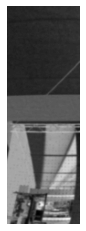

Predicted: tensor([9.9996e-01, 1.0608e-09, 3.6379e-05], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


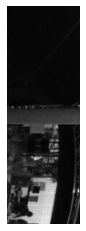

Predicted: tensor([1.6030e-17, 1.8367e-06, 1.0000e+00], device='cuda:0'), actual: tensor([0., 0., 1.], device='cuda:0')


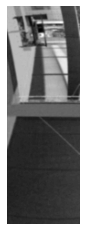

Predicted: tensor([3.2026e-04, 1.9414e-07, 9.9968e-01], device='cuda:0'), actual: tensor([0., 0., 1.], device='cuda:0')


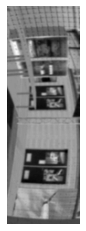

Predicted: tensor([1.4152e-06, 9.9999e-01, 4.4387e-06], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


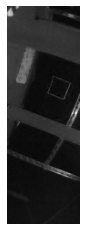

Predicted: tensor([0.0103, 0.9128, 0.0768], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


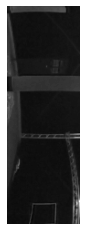

Predicted: tensor([1.8651e-05, 9.9997e-01, 7.5541e-06], device='cuda:0'), actual: tensor([0., 0., 1.], device='cuda:0')


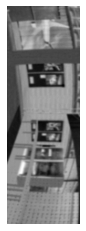

Predicted: tensor([5.1504e-05, 9.9995e-01, 9.0003e-09], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


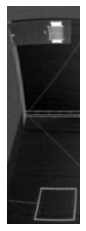

Predicted: tensor([2.6108e-08, 9.9997e-01, 2.6611e-05], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


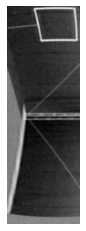

Predicted: tensor([4.8296e-03, 9.9511e-01, 6.0495e-05], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


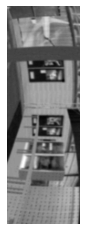

Predicted: tensor([3.5411e-04, 9.9965e-01, 6.8499e-09], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


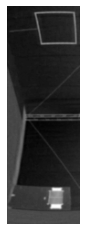

Predicted: tensor([2.7662e-05, 9.9997e-01, 1.2997e-08], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


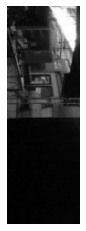

Predicted: tensor([4.8155e-12, 1.0000e+00, 4.6518e-18], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


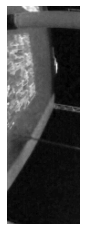

Predicted: tensor([1.3823e-01, 8.6177e-01, 2.8399e-06], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


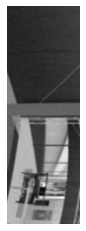

Predicted: tensor([9.9999e-01, 4.3215e-10, 1.3650e-05], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


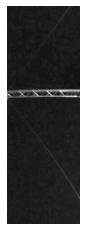

Predicted: tensor([0.2593, 0.7387, 0.0020], device='cuda:0'), actual: tensor([0., 0., 1.], device='cuda:0')


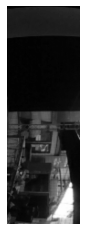

Predicted: tensor([2.1700e-15, 1.0000e+00, 3.9993e-17], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


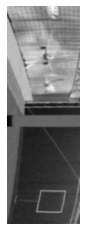

Predicted: tensor([9.9998e-01, 1.3740e-06, 1.4627e-05], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


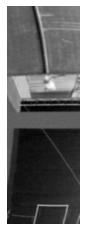

Predicted: tensor([9.9941e-01, 4.6085e-04, 1.2722e-04], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


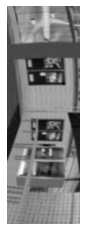

Predicted: tensor([1.2554e-05, 9.9999e-01, 3.8177e-10], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


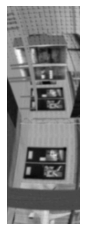

Predicted: tensor([8.8836e-08, 9.9993e-01, 6.7544e-05], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


In [ ]:
# Show test images together with the predicted and actual labels
def show_predictions(model, loader, num_images=5):
    """
    Show images together with the predicted and actual labels.

    Args:
        model: The model to use for prediction.
        loader: The DataLoader for the dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            for j in range(inputs.size(0)):
                img = inputs[j].permute(1, 2, 0).cpu().numpy()
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.show()
                print(f'Predicted: {outputs[j]}, actual: {labels[j]}')
                num_images -= 1
                if num_images == 0:
                    return

show_predictions(best_model, test_loader)

In [88]:
import os
sequence_path = 'test_sequence'

# fourcc and video for mp4 vidoe of the sequence, frames are RBG (540x270x3)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi',fourcc, 10, (520,240))

for filename in os.listdir(sequence_path):
    img_path = os.path.join(sequence_path, filename)
    img = cv2.imread(img_path)

    img_trans = copy.deepcopy(img)
    img_trans = IMAGE_TRANSFORM(img_trans).unsqueeze(0)
    img_trans = img_trans.to(device)

    output = best_model(img_trans)

    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # create bar chart from output, then add to image in top right corner
    img = cv2.rectangle(img, (5,5), (85,55), (0, 0, 0), -1)
    img = cv2.rectangle(img, (10,50-int(output[0][0]*40)), (30,50), (255, 255, 255), -1)
    img = cv2.rectangle(img, (35,50-int(output[0][1]*40)), (55,50), (255, 255, 255), -1)
    img = cv2.rectangle(img, (60,50-int(output[0][2]*40)), (80,50), (255, 255, 255), -1)

    video.write(img)

video.release()